#8. MODELLING.

##8.01 Initial work.

In [0]:
#Importing basic libraries:
import pandas as pd
import numpy as np
import timeit
import ujson
import os

In [189]:
#Click on the link, copy the authorization code and paste it on the box.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [190]:
#Now we have access to our own Google Drive account:
!ls -lh "/content/drive/My Drive/"

total 3.2G
drwx------ 2 root root 4.0K Jul 14 07:08  20180714_Deep_Learning
-rw------- 1 root root  76K Oct 22 18:13  6885.json
drwx------ 2 root root 4.0K Jun 26  2016 'avast! Files (XT1068, UWbYzWPVmAmwlrlD)'
-rw------- 1 root root 2.4M Nov 20 15:01  Cast_Crew_ids.csv
drwx------ 2 root root 4.0K Jul 18 18:38 'Colab Notebooks'
-rw------- 1 root root  44K Feb  4  2018  contacts.vcf
-rw------- 1 root root    1 Apr  9  2018  facturaIVA.gsheet
-rw------- 1 root root  50K Nov 19 21:17  genres.xlsx
-rw------- 1 root root 1.5M Oct 24 17:34  IMDB_5000_movie.csv
-rw------- 1 root root  12K Nov  3 10:33  InflationConverter.xlsx
-rw------- 1 root root    1 Nov 10 10:21 'Mis cuentas.gsheet'
-rw------- 1 root root  93K Nov 20 15:00  Movies_ids.csv
-rw------- 1 root root 2.8M Nov 19 22:08  MoviesUS.csv
-rw------- 1 root root 1.5G Oct 12 15:09  movies.zip
-rw------- 1 root root    1 Nov 17 16:27 'Nuestras Cuentas.gsheet'
-rw------- 1 root root 1.8G Oct 27 13:06  people.zip
-rw------- 1 root root 6.4

In [0]:
# Install the PyDrive wrapper & import libraries. This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Getting files from my Google Drive account:

#moviesUS data
file_id = '1-AHmt1vEuyHO6d-lxg1ygZZ4VuOZmJmm'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("MoviesUS.csv")

In [193]:
!ls -lh

total 2.9M
-rw-r--r-- 1 root root 2.5K Nov 21 21:26 adc.json
drwx------ 3 root root 4.0K Nov 21 21:26 drive
-rw-r--r-- 1 root root 2.8M Nov 21 22:30 MoviesUS.csv
drwxr-xr-x 2 root root 4.0K Nov 20 18:17 sample_data


##8.02 Importing the data.

Now let's import the file we built with all our features:

In [194]:
my_file_path='./MoviesUS.csv'

#Reading file and saving in df
dfMoviesUS = pd.read_csv(my_file_path)
dfMoviesUS = dfMoviesUS.drop('movie_id.1', axis=1)
dfMoviesUS.shape

(8373, 74)

In [195]:
dfMoviesUS.columns

Index(['movie_id', 'title', 'original_title', 'original_language', 'status',
       'release_date', 'release_year', 'runtime', 'revenue_tmdb_imdb',
       'budget_tmdb_imdb', 'InflationConverter', 'revenue_inflation_adjusted',
       'budget_inflation_adjusted', 'intAnnual', '3FirstRoles_High',
       '3FirstRoles_Medium', '3FirstRoles_Low', 'OtherRoles_High',
       'OtherRoles_Medium', 'OtherRoles_Low', 'indAnimationMusic',
       'indFantasyScienceFiction', 'indDocumentaryHistoryWar', 'indRomance',
       'indComedy', 'indThrillerHorrorActionCrimeMystery', 'indDrama',
       'indLang_ENG', 'indCountries_US_only', 'indCountries_US_and_oth',
       'indCountries_Eur_only', 'indCountries_Other', 'indCertific_G_PG',
       'indCertific_PG13', 'indCertific_R_NC17', 'percentProducer_0',
       'percentProducer_1', 'percentProducer_2', 'percentExecutive Producer_0',
       'percentExecutive Producer_1', 'percentExecutive Producer_2',
       'percentDirector_0', 'percentDirector_1', 'percen

We will select now the features that can go into our model (we will exclude one of the indicators in every group of indicators when appropiate).

In [196]:
myFeaturesList = ['revenue_inflation_adjusted', 'budget_inflation_adjusted', 'runtime', 'intAnnual'] + dfMoviesUS.columns[dfMoviesUS.columns.str.contains('Roles')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('ind')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('percent')].tolist()
myFeaturesList.remove('indDrama')
myFeaturesList.remove('indCountries_Other')
myFeaturesList = list(set(myFeaturesList) - set(dfMoviesUS.columns[(dfMoviesUS.columns.str.startswith('percent')) & (dfMoviesUS.columns.str.contains('_2'))].tolist()))
myFeaturesList.sort()
len(myFeaturesList)

49

In [197]:
dfMoviesUS[dfMoviesUS.columns[dfMoviesUS.columns.isin(myFeaturesList)]].shape

(8373, 49)

In [198]:
#All my features are numeric.
dfMoviesUS[dfMoviesUS.columns[dfMoviesUS.columns.isin(myFeaturesList)]].dtypes

runtime                                float64
revenue_inflation_adjusted             float64
budget_inflation_adjusted              float64
intAnnual                                int64
3FirstRoles_High                       float64
3FirstRoles_Medium                     float64
3FirstRoles_Low                        float64
OtherRoles_High                        float64
OtherRoles_Medium                      float64
OtherRoles_Low                         float64
indAnimationMusic                        int64
indFantasyScienceFiction                 int64
indDocumentaryHistoryWar                 int64
indRomance                               int64
indComedy                                int64
indThrillerHorrorActionCrimeMystery      int64
indLang_ENG                              int64
indCountries_US_only                     int64
indCountries_US_and_oth                  int64
indCountries_Eur_only                    int64
indCertific_G_PG                         int64
indCertific_P

In [199]:
#Las únicas variables con nulos son runtime y budget_inflation_adjusted. Para cast y crew tomé el criterio de transformarlos en 0.
dfMoviesUS[dfMoviesUS.columns[dfMoviesUS.columns.isin(myFeaturesList)]].isnull().sum()

runtime                                  23
revenue_inflation_adjusted                0
budget_inflation_adjusted              2131
intAnnual                                 0
3FirstRoles_High                          0
3FirstRoles_Medium                        0
3FirstRoles_Low                           0
OtherRoles_High                           0
OtherRoles_Medium                         0
OtherRoles_Low                            0
indAnimationMusic                         0
indFantasyScienceFiction                  0
indDocumentaryHistoryWar                  0
indRomance                                0
indComedy                                 0
indThrillerHorrorActionCrimeMystery       0
indLang_ENG                               0
indCountries_US_only                      0
indCountries_US_and_oth                   0
indCountries_Eur_only                     0
indCertific_G_PG                          0
indCertific_PG13                          0
indCertific_R_NC17              

In [200]:
#¿Tengo 0's en estas variables?
dfMoviesUS[['revenue_inflation_adjusted', 'budget_inflation_adjusted', 'runtime']].applymap(lambda x: x==0).sum()

revenue_inflation_adjusted    0
budget_inflation_adjusted     0
runtime                       0
dtype: int64

##8.03 Correcting errors.

We will analyze extreme values for budget and revenue that could produce outliers that would impact negatively in our model.

We will create columns **`budget_tmdb_imdb_corrected`** and **`revenue_tmdb_imdb_corrected`** to keep memory of corrections. In every case, we will include a link to the documentation used to make the correction.

In [0]:
dfMoviesUS['budget_tmdb_imdb_corrected'] = None
dfMoviesUS['revenue_tmdb_imdb_corrected'] = None

**Checking movies with budget higher than "Avatar", the most expensive movie in history:**

In [202]:
#¿Qué pelis tienen presupuesto mayor que el de avatar?
dfMoviesUS[dfMoviesUS['budget_inflation_adjusted']>425e6].shape[0]

7

In [203]:
dfMoviesUS[dfMoviesUS['budget_inflation_adjusted']>425e6][['movie_id', 'title', 'release_year', 'budget_inflation_adjusted', 'budget_tmdb_imdb', 'budget_tmdb_imdb_corrected', 'revenue_inflation_adjusted', 'revenue_tmdb_imdb', 'revenue_tmdb_imdb_corrected','indCountries_US_only', 'indCountries_US_and_oth', 'indLang_ENG']]

,movie_id,title,release_year,budget_inflation_adjusted,budget_tmdb_imdb,budget_tmdb_imdb_corrected,revenue_inflation_adjusted,revenue_tmdb_imdb,revenue_tmdb_imdb_corrected,indCountries_US_only,indCountries_US_and_oth,indLang_ENG
144,1865,Pirates of the Caribbean: On Stranger Tides,2011,4.264740e+08,3.800000e+08,None,1.173605e+09,1.045714e+09,None,1,0,1
913,65749,Tango,1998,1.084090e+09,7.000000e+08,None,2.613139e+06,1.687311e+06,None,0,0,0
3010,27329,The Legend of Suriyothai,2001,5.704800e+08,4.000000e+08,None,6.478585e+05,4.542550e+05,None,0,0,0
5056,37737,Kites,2010,6.946200e+08,6.000000e+08,None,1.855175e+06,1.602466e+06,None,0,0,0
5092,4550,Sympathy for Lady Vengeance,2005,5.428920e+09,4.200000e+09,None,3.076816e+07,2.380331e+07,None,0,0,0
6600,141052,Justice League,2017,5.149500e+08,5.000000e+08,None,6.775962e+08,6.579243e+08,None,1,0,1
8320,982,The Manchurian Candidate,1962,6.687120e+08,8.000000e+07,None,8.033397e+08,9.610591e+07,None,1,0,1


In [0]:
#https://www.the-numbers.com/movie/Tango#tab=summary
#https://www.imdb.com/title/tt0120274/?ref_=fn_al_tt_2
dfMoviesUS.loc[dfMoviesUS['movie_id']==65749, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==65749, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==65749, 'budget_tmdb_imdb'] = 4.5e6

#Worldwide box office numbers if they are available. Otherwise US only is fine.
dfMoviesUS.loc[dfMoviesUS['movie_id']==65749, 'revenue_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==65749, 'revenue_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==65749, 'revenue_tmdb_imdb'] = 5428387

In [0]:
#https://www.imdb.com/title/tt0056218/
#https://www.the-numbers.com/search?searchterm=the+manchurian+candidate
dfMoviesUS.loc[dfMoviesUS['movie_id']==982, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==982, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==982, 'budget_tmdb_imdb'] = 2.2e6

#Worldwide box office numbers if they are available. Otherwise US only is fine.
dfMoviesUS.loc[dfMoviesUS['movie_id']==982, 'revenue_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==982, 'revenue_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==982, 'revenue_tmdb_imdb'] = 7.7e6

In [0]:
#https://www.imdb.com/title/tt0974015/?ref_=nv_sr_1
dfMoviesUS.loc[dfMoviesUS['movie_id']==141052, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==141052, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==141052, 'budget_tmdb_imdb'] = 3e8

In [0]:
#https://www.the-numbers.com/movie/budgets
#https://www.imdb.com/title/tt1298650/?ref_=fn_al_tt_1
#Piratas del caribe: ingresos correcto. Budget: no hay base para decir que esté mal.

In [0]:
#https://www.the-numbers.com/movie/Chinjeolhan-geumjassi#tab=summary
#https://www.imdb.com/title/tt0451094/?ref_=nv_sr_1
dfMoviesUS.loc[dfMoviesUS['movie_id']==4550, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==4550, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==4550, 'budget_tmdb_imdb'] = 4.5e6

In [0]:
#https://www.the-numbers.com/movie/Kites#tab=summary
dfMoviesUS.loc[dfMoviesUS['movie_id']==37737, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==37737, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==37737, 'budget_tmdb_imdb'] = 9.2e6

#Worldwide box office numbers if they are available. Otherwise US only is fine.
dfMoviesUS.loc[dfMoviesUS['movie_id']==37737, 'revenue_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==37737, 'revenue_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==37737, 'revenue_tmdb_imdb'] = 17155193

In [0]:
#https://www.the-numbers.com/movie/Legend-of-Suriyothai-The#tab=summary
dfMoviesUS.loc[dfMoviesUS['movie_id']==27329, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==27329, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==27329, 'budget_tmdb_imdb'] = 9e6

**Checking movies with the highest revenue:**

In [211]:
dfMoviesUS[['movie_id', 'title', 'release_year', 'revenue_inflation_adjusted', 'revenue_tmdb_imdb', 'revenue_tmdb_imdb_corrected', 'budget_inflation_adjusted', 'budget_tmdb_imdb', 'budget_tmdb_imdb_corrected', 'indCountries_US_only', 'indCountries_US_and_oth', 'indLang_ENG']].sort_values(by='revenue_inflation_adjusted', ascending=False).head(10)

,movie_id,title,release_year,revenue_inflation_adjusted,revenue_tmdb_imdb,revenue_tmdb_imdb_corrected,budget_inflation_adjusted,budget_tmdb_imdb,budget_tmdb_imdb_corrected,indCountries_US_only,indCountries_US_and_oth,indLang_ENG
8294,12092,Alice in Wonderland,1951,5.553662e+09,5.720000e+08,None,29127600.0,3000000.0,None,1,0,1
5739,19995,Avatar,2009,3.280599e+09,2.787965e+09,None,278877900.0,237000000.0,None,0,1,1
8217,11,Star Wars,1977,3.230075e+09,7.753980e+08,None,45822700.0,11000000.0,None,1,0,1
6144,597,Titanic,1997,2.901870e+09,1.845034e+09,None,314560000.0,200000000.0,None,1,0,1
8365,11224,Cinderella,1950,2.761015e+09,2.635914e+08,None,30376340.0,2900000.0,None,1,0,1
6493,9552,The Exorcist,1973,2.509090e+09,4.413061e+08,None,45484800.0,8000000.0,None,1,0,1
4651,15121,The Sound of Music,1965,2.293693e+09,2.862143e+08,None,65713980.0,8200000.0,None,1,0,1
7785,578,Jaws,1975,2.208619e+09,4.707000e+08,None,32845400.0,7000000.0,None,1,0,1
3464,140607,Star Wars: The Force Awakens,2015,2.202865e+09,2.068224e+09,None,260949500.0,245000000.0,None,1,0,1
7491,601,E.T. the Extra-Terrestrial,1982,2.074318e+09,7.929653e+08,None,27466950.0,10500000.0,None,1,0,1


In [0]:
#https://www.imdb.com/title/tt0073195/?ref_=fn_al_tt_1
dfMoviesUS.loc[dfMoviesUS['movie_id']==578, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==578, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==578, 'budget_tmdb_imdb'] = 8e6

In [0]:
#https://www.the-numbers.com/movie/Exorcist-The#tab=summary
dfMoviesUS.loc[dfMoviesUS['movie_id']==9552, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==9552, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==9552, 'budget_tmdb_imdb'] = 12e6

#Worldwide box office numbers if they are available. Otherwise US only is fine.
dfMoviesUS.loc[dfMoviesUS['movie_id']==9552, 'revenue_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==9552, 'revenue_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==9552, 'revenue_tmdb_imdb'] = 430773277

In [0]:
#https://www.imdb.com/title/tt0043274/?ref_=fn_al_tt_2
dfMoviesUS.loc[dfMoviesUS['movie_id']==12092, 'revenue_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==12092, 'revenue_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==12092, 'revenue_tmdb_imdb'] = 5232000

In [0]:
#Avatar: ok
#https://www.imdb.com/title/tt0499549/?ref_=fn_al_tt_1

**Checking the most profitable movies:**

In [216]:
dfMoviesUS['profit_inflation_adjusted'] = dfMoviesUS['revenue_inflation_adjusted'] - dfMoviesUS['budget_inflation_adjusted']
dfMoviesUS[['budget_inflation_adjusted', 'revenue_inflation_adjusted', 'profit_inflation_adjusted']].isnull().sum()

budget_inflation_adjusted     2131
revenue_inflation_adjusted       0
profit_inflation_adjusted     2131
dtype: int64

In [217]:
dfMoviesUS[['movie_id', 'title', 'release_year', 'profit_inflation_adjusted', 'revenue_inflation_adjusted', 'revenue_tmdb_imdb', 'revenue_tmdb_imdb_corrected', 'budget_inflation_adjusted', 'budget_tmdb_imdb', 'budget_tmdb_imdb_corrected', 'indCountries_US_only', 'indCountries_US_and_oth', 'indLang_ENG']].sort_values(by='profit_inflation_adjusted', ascending=False).head(10)

,movie_id,title,release_year,profit_inflation_adjusted,revenue_inflation_adjusted,revenue_tmdb_imdb,revenue_tmdb_imdb_corrected,budget_inflation_adjusted,budget_tmdb_imdb,budget_tmdb_imdb_corrected,indCountries_US_only,indCountries_US_and_oth,indLang_ENG
8294,12092,Alice in Wonderland,1951,5.524535e+09,5.553662e+09,5.232000e+06,5.72e+08,29127600.0,3000000.0,None,1,0,1
8217,11,Star Wars,1977,3.184253e+09,3.230075e+09,7.753980e+08,None,45822700.0,11000000.0,None,1,0,1
5739,19995,Avatar,2009,3.001721e+09,3.280599e+09,2.787965e+09,None,278877900.0,237000000.0,None,0,1,1
8365,11224,Cinderella,1950,2.730638e+09,2.761015e+09,2.635914e+08,None,30376340.0,2900000.0,None,1,0,1
6144,597,Titanic,1997,2.587310e+09,2.901870e+09,1.845034e+09,None,314560000.0,200000000.0,None,1,0,1
6493,9552,The Exorcist,1973,2.463605e+09,2.509090e+09,4.307733e+08,4.41306e+08,45484800.0,12000000.0,8e+06,1,0,1
4651,15121,The Sound of Music,1965,2.227979e+09,2.293693e+09,2.862143e+08,None,65713980.0,8200000.0,None,1,0,1
7785,578,Jaws,1975,2.175773e+09,2.208619e+09,4.707000e+08,None,32845400.0,8000000.0,7e+06,1,0,1
7491,601,E.T. the Extra-Terrestrial,1982,2.046851e+09,2.074318e+09,7.929653e+08,None,27466950.0,10500000.0,None,1,0,1
3464,140607,Star Wars: The Force Awakens,2015,1.941915e+09,2.202865e+09,2.068224e+09,None,260949500.0,245000000.0,None,1,0,1


**`Checking the least profitable movies`**:

In [218]:
dfMoviesUS[dfMoviesUS['profit_inflation_adjusted'].notnull()][['movie_id', 'title', 'release_year', 'profit_inflation_adjusted', 'revenue_inflation_adjusted', 'revenue_tmdb_imdb', 'revenue_tmdb_imdb_corrected', 'budget_inflation_adjusted', 'budget_tmdb_imdb', 'budget_tmdb_imdb_corrected', 'indCountries_US_only', 'indCountries_US_and_oth', 'indLang_ENG']].sort_values(by='profit_inflation_adjusted', ascending=False).tail(10)

,movie_id,title,release_year,profit_inflation_adjusted,revenue_inflation_adjusted,revenue_tmdb_imdb,revenue_tmdb_imdb_corrected,budget_inflation_adjusted,budget_tmdb_imdb,budget_tmdb_imdb_corrected,indCountries_US_only,indCountries_US_and_oth,indLang_ENG
1056,9045,Amen.,2002,-1.441447e+08,3.848964e+05,274299.0,None,1.445296e+08,103000000.0,None,0,0,0
6903,1408,Cutthroat Island,1995,-1.457345e+08,1.659269e+07,10017322.0,None,1.623272e+08,98000000.0,None,0,1,1
517,1911,The 13th Warrior,1999,-1.489458e+08,9.348617e+07,61698899.0,None,2.424320e+08,160000000.0,None,1,0,1
3223,10733,The Alamo,2004,-1.592722e+08,3.450580e+07,25819961.0,None,1.937780e+08,145000000.0,None,1,0,1
2147,57201,The Lone Ranger,2013,-1.795635e+08,9.675455e+07,89289910.0,None,2.763180e+08,255000000.0,None,1,0,1
845,10353,The Visitors II: The Corridors of Time,1998,-2.165918e+08,2.262217e+05,146072.0,None,2.168180e+08,140000000.0,None,0,0,0
3010,27329,The Legend of Suriyothai,2001,-5.698321e+08,6.478585e+05,454255.0,None,5.704800e+08,9000000.0,4e+08,0,0,0
5056,37737,Kites,2010,-6.927648e+08,1.855175e+06,17155193.0,1.60247e+06,6.946200e+08,9200000.0,6e+08,0,0,0
913,65749,Tango,1998,-1.081477e+09,2.613139e+06,5428387.0,1.68731e+06,1.084090e+09,4500000.0,7e+08,0,0,0
5092,4550,Sympathy for Lady Vengeance,2005,-5.398152e+09,3.076816e+07,23803308.0,None,5.428920e+09,4500000.0,4.2e+09,0,0,0


In [0]:
#https://www.the-numbers.com/movie/Cutthroat-Island#tab=summary
dfMoviesUS.loc[dfMoviesUS['movie_id']==48217, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==48217, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==48217, 'budget_tmdb_imdb'] = 15315028

In [0]:
#Sin otras referencias de Waterloo

In [0]:
#https://www.the-numbers.com/movie/Cutthroat-Island#tab=summary
dfMoviesUS.loc[dfMoviesUS['movie_id']==1408, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==1408, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==1408, 'budget_tmdb_imdb'] = 92e6

#Worldwide box office numbers if they are available. Otherwise US only is fine.
dfMoviesUS.loc[dfMoviesUS['movie_id']==1408, 'revenue_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==1408, 'revenue_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==1408, 'revenue_tmdb_imdb'] = 18517322

In [0]:
#https://www.the-numbers.com/movie/Amen#tab=summary
#https://www.imdb.com/title/tt0280653/?ref_=fn_al_tt_1
dfMoviesUS.loc[dfMoviesUS['movie_id']==9045, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==9045, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==9045, 'budget_tmdb_imdb'] = 14e6

In [0]:
#https://www.the-numbers.com/movie/Alamo-The-(2004)#tab=summary
dfMoviesUS.loc[dfMoviesUS['movie_id']==10733, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==10733, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==10733, 'budget_tmdb_imdb'] = 92e6

#Worldwide box office numbers if they are available. Otherwise US only is fine.
dfMoviesUS.loc[dfMoviesUS['movie_id']==10733, 'revenue_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==10733, 'revenue_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==10733, 'revenue_tmdb_imdb'] = 23911362

In [0]:
#https://www.the-numbers.com/movie/Lone-Ranger-The#tab=summary
dfMoviesUS.loc[dfMoviesUS['movie_id']==57201, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==57201, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==57201, 'budget_tmdb_imdb'] = 275e6

#Worldwide box office numbers if they are available. Otherwise US only is fine.
dfMoviesUS.loc[dfMoviesUS['movie_id']==57201, 'revenue_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==57201, 'revenue_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==57201, 'revenue_tmdb_imdb'] = 260002115

In [0]:
#https://www.the-numbers.com/movie/Couloirs-du-temps-Les-visiteurs-2-Les#tab=summary
dfMoviesUS.loc[dfMoviesUS['movie_id']==10353, 'budget_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==10353, 'budget_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==10353, 'budget_tmdb_imdb'] = 20e6

#Worldwide box office numbers if they are available. Otherwise US only is fine.
dfMoviesUS.loc[dfMoviesUS['movie_id']==10353, 'revenue_tmdb_imdb_corrected'] = dfMoviesUS.loc[dfMoviesUS['movie_id']==10353, 'revenue_tmdb_imdb']
dfMoviesUS.loc[dfMoviesUS['movie_id']==10353, 'revenue_tmdb_imdb'] = 26146072

In [0]:
#Tras las correcciones, recalculo todo:
dfMoviesUS['revenue_inflation_adjusted'] = dfMoviesUS['revenue_tmdb_imdb'] * dfMoviesUS['InflationConverter']/100
dfMoviesUS['budget_inflation_adjusted'] = dfMoviesUS['budget_tmdb_imdb'] * dfMoviesUS['InflationConverter']/100
dfMoviesUS['profit_inflation_adjusted'] = dfMoviesUS['revenue_inflation_adjusted'] - dfMoviesUS['budget_inflation_adjusted']

In [227]:
dfMoviesUS[dfMoviesUS['budget_inflation_adjusted']>=3e8].shape[0]

7

In [228]:
dfMoviesUS[dfMoviesUS['budget_inflation_adjusted']>=3e8][['movie_id', 'title', 'release_year', 'profit_inflation_adjusted', 'revenue_inflation_adjusted', 'revenue_tmdb_imdb', 'revenue_tmdb_imdb_corrected', 'budget_inflation_adjusted', 'budget_tmdb_imdb', 'budget_tmdb_imdb_corrected', 'indCountries_US_only', 'indCountries_US_and_oth', 'indLang_ENG']].sort_values(by='budget_inflation_adjusted', ascending=False)

,movie_id,title,release_year,profit_inflation_adjusted,revenue_inflation_adjusted,revenue_tmdb_imdb,revenue_tmdb_imdb_corrected,budget_inflation_adjusted,budget_tmdb_imdb,budget_tmdb_imdb_corrected,indCountries_US_only,indCountries_US_and_oth,indLang_ENG
144,1865,Pirates of the Caribbean: On Stranger Tides,2011,7.471306e+08,1.173605e+09,1.045714e+09,None,426474000.0,380000000.0,None,1,0,1
7088,285,Pirates of the Caribbean: At World's End,2007,8.047675e+08,1.170018e+09,9.610000e+08,None,365250000.0,300000000.0,None,1,0,1
4442,1452,Superman Returns,2006,1.516179e+08,4.897119e+08,3.910812e+08,None,338094000.0,270000000.0,None,1,0,1
6144,597,Titanic,1997,2.587310e+09,2.901870e+09,1.845034e+09,None,314560000.0,200000000.0,None,1,0,1
7077,559,Spider-Man 3,2007,7.705212e+08,1.084636e+09,8.908716e+08,None,314115000.0,258000000.0,None,1,0,1
6600,141052,Justice League,2017,3.686262e+08,6.775962e+08,6.579243e+08,None,308970000.0,300000000.0,5e+08,1,0,1
4964,38757,Tangled,2010,3.841190e+08,6.851210e+08,5.917949e+08,None,301002000.0,260000000.0,None,1,0,1


##8.04 Completing null values.

**Runtime**:

We have only 23 rows where **`runtime`** is null. We will complete those values with the median:

In [0]:
dfMoviesUS = dfMoviesUS.fillna({'runtime': dfMoviesUS['runtime'].median()})   

**Genre indicators:**

We will assign the 42 null values to the existing categories proportionally to their weights on the overall volume of rows.

In [230]:
#42 sin info + 1 de una categoría errónea
dfMoviesUS.groupby(['indAnimationMusic', 'indFantasyScienceFiction', 'indDocumentaryHistoryWar', 'indRomance', 'indComedy', 'indDrama', 'indThrillerHorrorActionCrimeMystery'])['status'].count().reset_index().sort_values(by='status', ascending=False)

,indAnimationMusic,indFantasyScienceFiction,indDocumentaryHistoryWar,indRomance,indComedy,indDrama,indThrillerHorrorActionCrimeMystery,status
1,0,0,0,0,0,0,1,1958
3,0,0,0,0,1,0,0,1603
4,0,0,0,1,0,0,0,1326
6,0,1,0,0,0,0,0,1184
2,0,0,0,0,0,1,0,787
5,0,0,1,0,0,0,0,760
7,1,0,0,0,0,0,0,712
0,0,0,0,0,0,0,0,43


In [231]:
auxGenreNullIds = dfMoviesUS[(dfMoviesUS['indAnimationMusic']==0) & (dfMoviesUS['indFantasyScienceFiction']==0) & (dfMoviesUS['indDocumentaryHistoryWar']==0) & (dfMoviesUS['indRomance']==0) & (dfMoviesUS['indComedy']==0) & (dfMoviesUS['indThrillerHorrorActionCrimeMystery']==0) & (dfMoviesUS['indDrama']==0)]['movie_id'].tolist()
len(auxGenreNullIds)

43

In [0]:
dfMoviesUS['indGenreNull'] = None
dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(auxGenreNullIds), 'indGenreNull'] = 1

In [233]:
updatingList = list()

for column in ['indAnimationMusic', 'indFantasyScienceFiction', 'indDocumentaryHistoryWar', 'indRomance', 'indComedy', 'indDrama']:
    updatingList = updatingList + [round(len(auxGenreNullIds) * dfMoviesUS[dfMoviesUS[column]==1].shape[0] / (dfMoviesUS.shape[0] - len(auxGenreNullIds)))]

updatingList = updatingList + [len(auxGenreNullIds)-sum(updatingList)]
updatingList

[4, 6, 4, 7, 8, 4, 10]

In [0]:
np.random.seed(100)
np.random.shuffle(auxGenreNullIds)

auxInt1 = 0
auxInt2 = 0

for column in ['indAnimationMusic', 'indFantasyScienceFiction', 'indDocumentaryHistoryWar', 'indRomance', 'indComedy', 'indDrama', 'indThrillerHorrorActionCrimeMystery']:
    dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(auxGenreNullIds[auxInt1:auxInt1+updatingList[auxInt2]]), column] = 1
    auxInt1 = auxInt1 + updatingList[auxInt2]
    auxInt2 += 1    

In [235]:
#42 sin info + 1 de una categoría errónea
dfMoviesUS.groupby(['indAnimationMusic', 'indFantasyScienceFiction', 'indDocumentaryHistoryWar', 'indRomance', 'indComedy', 'indDrama', 'indThrillerHorrorActionCrimeMystery'])['status'].count().reset_index().sort_values(by='status', ascending=False)

,indAnimationMusic,indFantasyScienceFiction,indDocumentaryHistoryWar,indRomance,indComedy,indDrama,indThrillerHorrorActionCrimeMystery,status
0,0,0,0,0,0,0,1,1968
2,0,0,0,0,1,0,0,1611
3,0,0,0,1,0,0,0,1333
5,0,1,0,0,0,0,0,1190
1,0,0,0,0,0,1,0,791
4,0,0,1,0,0,0,0,764
6,1,0,0,0,0,0,0,716


**Original language:**

In [236]:
#No nulls!
dfMoviesUS['indLang_ENG'].value_counts()

1    7451
0     922
Name: indLang_ENG, dtype: int64

**Production countries:**

We will assign the 248 null values to the existing categories proportionally to their weights on the overall volume of rows.

In [237]:
#248 sin info
dfMoviesUS.groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('indCountries')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False)

,indCountries_US_only,indCountries_US_and_oth,indCountries_Eur_only,indCountries_Other,status
4,1,0,0,0,5055
3,0,1,0,0,1490
2,0,0,1,0,898
1,0,0,0,1,682
0,0,0,0,0,248


In [238]:
auxCountriesNullIds = dfMoviesUS[(dfMoviesUS['indCountries_US_only']==0) & (dfMoviesUS['indCountries_US_and_oth']==0) & (dfMoviesUS['indCountries_Eur_only']==0) & (dfMoviesUS['indCountries_Other']==0)]['movie_id'].tolist()
len(auxCountriesNullIds)

248

In [0]:
dfMoviesUS['indCountryNull'] = None
dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(auxCountriesNullIds), 'indCountryNull'] = 1

In [240]:
updatingList = list()

for column in ['indCountries_US_and_oth', 'indCountries_Eur_only', 'indCountries_Other']:
    updatingList = updatingList + [round(len(auxCountriesNullIds) * dfMoviesUS[dfMoviesUS[column]==1].shape[0] / (dfMoviesUS.shape[0] - len(auxCountriesNullIds)))]

updatingList = updatingList + [len(auxCountriesNullIds)-sum(updatingList)]
updatingList

[45, 27, 21, 155]

In [0]:
np.random.seed(100)
np.random.shuffle(auxCountriesNullIds)

auxInt1 = 0
auxInt2 = 0

for column in ['indCountries_US_and_oth', 'indCountries_Eur_only', 'indCountries_Other', 'indCountries_US_only']:
    dfMoviesUS.loc[dfMoviesUS['movie_id'].isin(auxCountriesNullIds[auxInt1:auxInt1+updatingList[auxInt2]]), column] = 1
    auxInt1 = auxInt1 + updatingList[auxInt2]
    auxInt2 += 1  

In [242]:
dfMoviesUS.groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('indCountries')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False)

,indCountries_US_only,indCountries_US_and_oth,indCountries_Eur_only,indCountries_Other,status
3,1,0,0,0,5210
2,0,1,0,0,1535
1,0,0,1,0,925
0,0,0,0,1,703


**Certifications:**

We assumed that null values represented "not rated".

In [243]:
dfMoviesUS.groupby(dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('indCertific')].tolist())['status'].count().reset_index().sort_values(by='status', ascending=False)

,indCertific_G_PG,indCertific_PG13,indCertific_R_NC17,status
1,0,0,1,3348
2,0,1,0,1998
0,0,0,0,1586
3,1,0,0,1441


##8.04 Modelling.

Revenue and budget are highly right skewed. We will tranform them using log.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

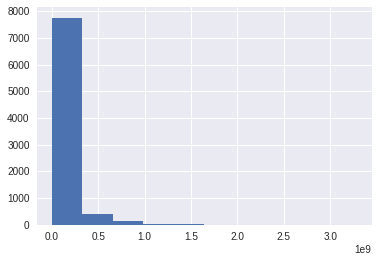

In [245]:
plt.hist(dfMoviesUS['revenue_inflation_adjusted']);

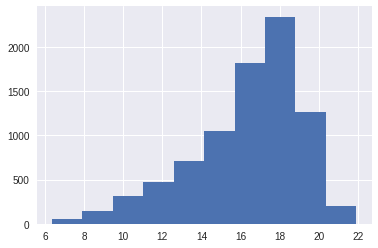

In [246]:
plt.hist(dfMoviesUS['revenue_inflation_adjusted'].map(lambda x: np.log(x)));

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


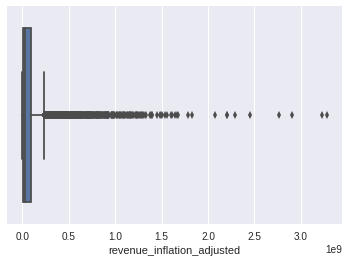

In [247]:
sns.boxplot(dfMoviesUS['revenue_inflation_adjusted']);
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


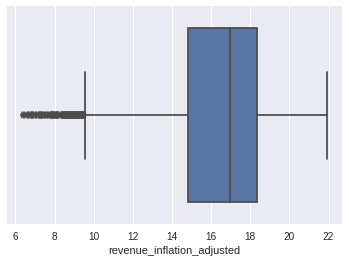

In [248]:
sns.boxplot(dfMoviesUS['revenue_inflation_adjusted'].map(lambda x: np.log(x)));
plt.show()

**Budget versus revenue:**

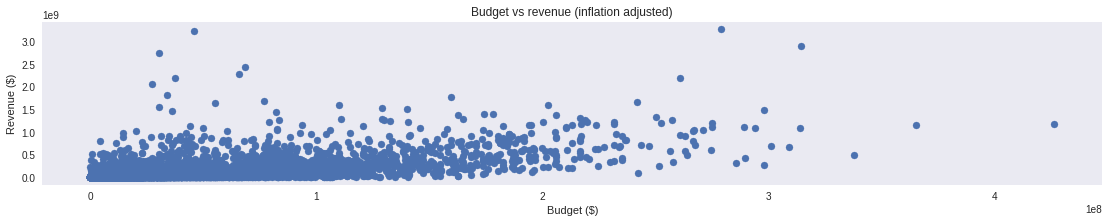

In [249]:
%matplotlib inline
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1,1)

plt.scatter(dfMoviesUS[dfMoviesUS['budget_inflation_adjusted'].notnull()]['budget_inflation_adjusted'], dfMoviesUS[dfMoviesUS['budget_inflation_adjusted']>0]['revenue_inflation_adjusted'])
plt.grid(False)

plt.title('Budget vs revenue (inflation adjusted)')
plt.xlabel('Budget ($)')
plt.ylabel('Revenue ($)')

figure.set_size_inches([19,3])

plt.show()

In [250]:
myFeaturesList = ['budget_inflation_adjusted', 'runtime', 'intAnnual'] + dfMoviesUS.columns[dfMoviesUS.columns.str.contains('Roles')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('ind')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('percent')].tolist()
myFeaturesList.remove('indDrama')
myFeaturesList.remove('indCountries_Other')
myFeaturesList.remove('indCountryNull')
myFeaturesList.remove('indGenreNull')
myFeaturesList = list(set(myFeaturesList) - set(dfMoviesUS.columns[(dfMoviesUS.columns.str.startswith('percent')) & (dfMoviesUS.columns.str.contains('_2'))].tolist()))
myFeaturesList.sort()

len(myFeaturesList)

48

Let's get histograms for all our features:

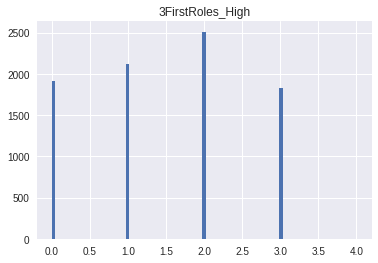

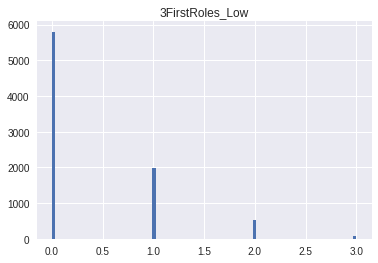

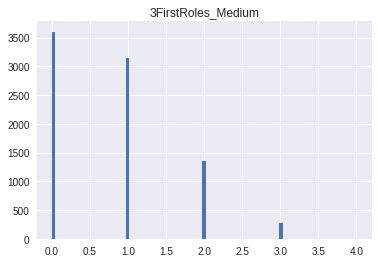

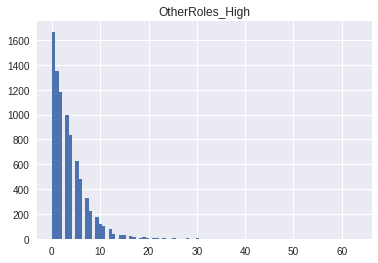

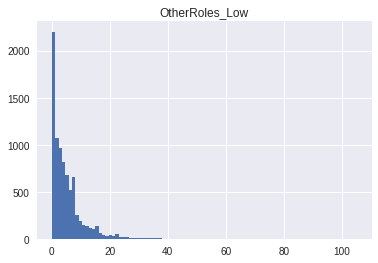

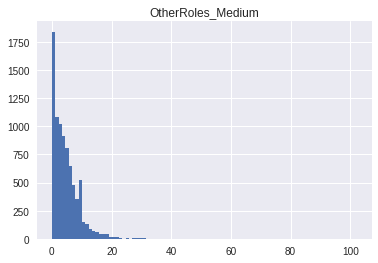

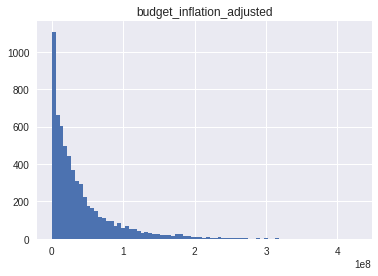

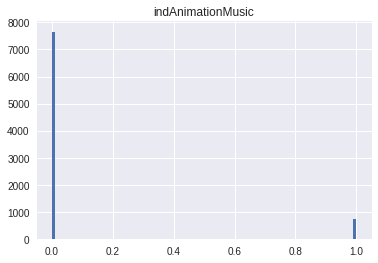

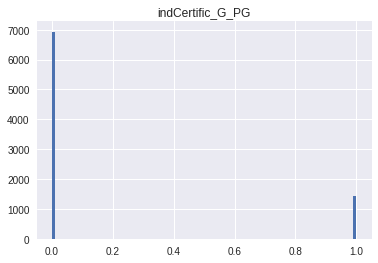

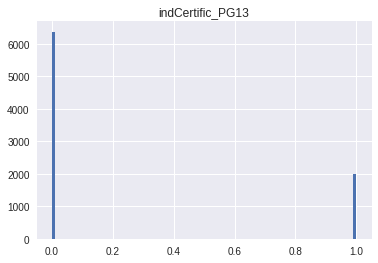

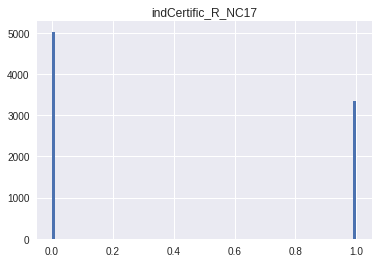

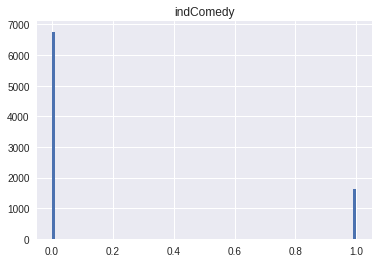

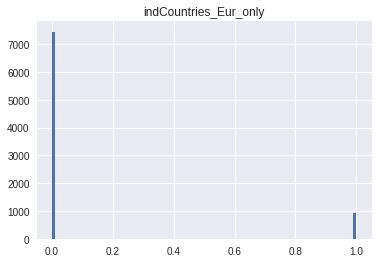

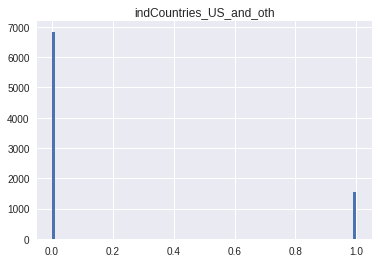

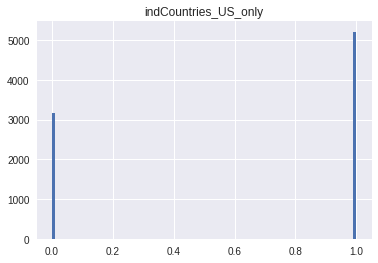

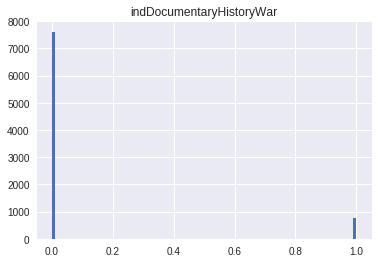

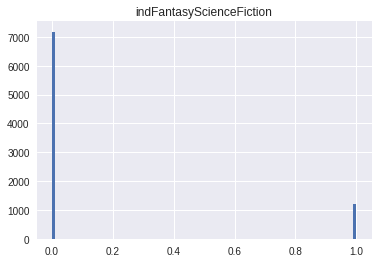

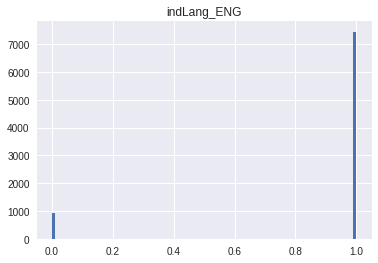

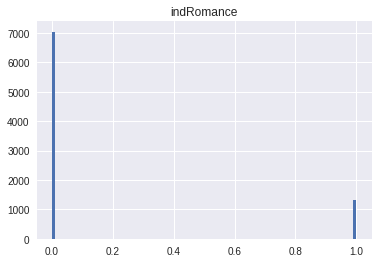

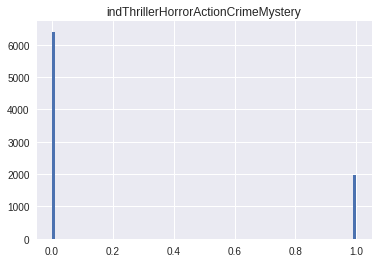

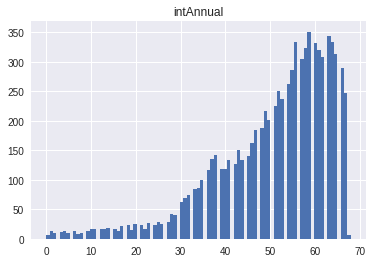

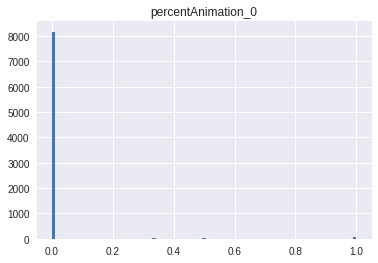

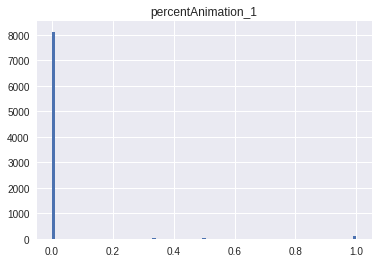

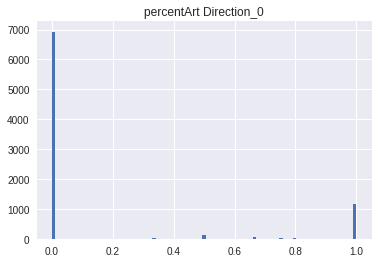

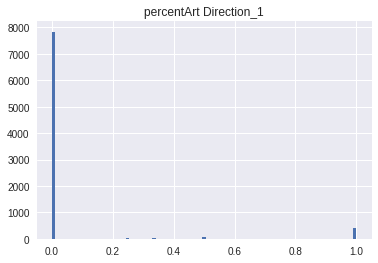

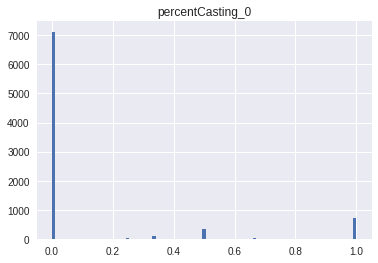

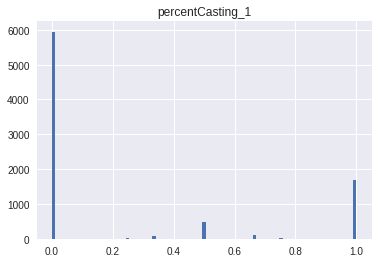

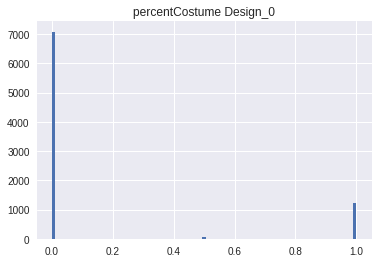

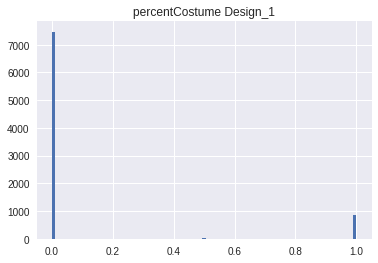

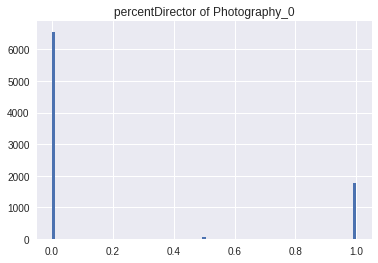

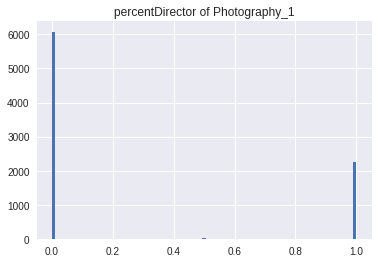

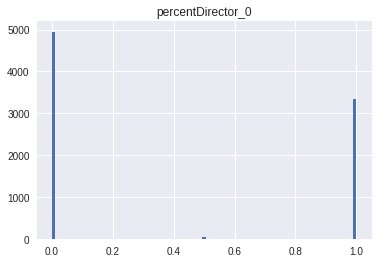

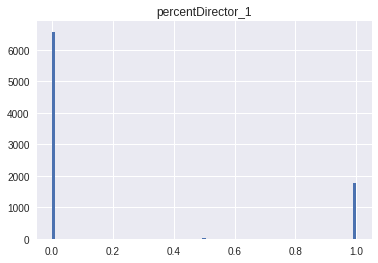

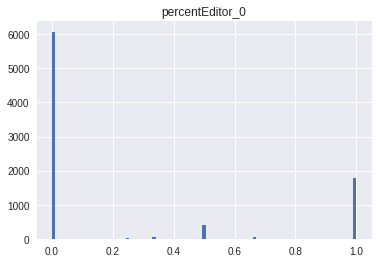

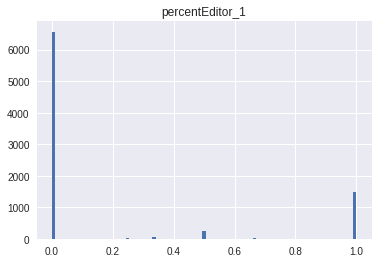

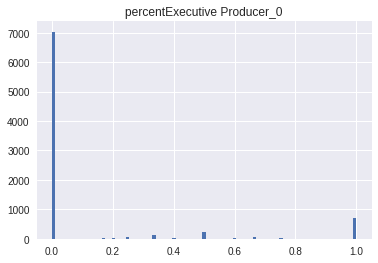

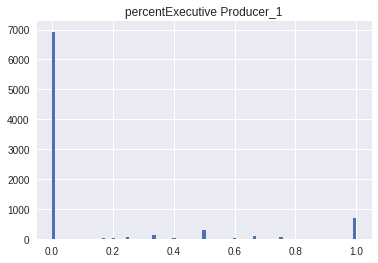

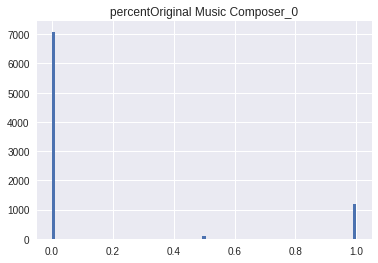

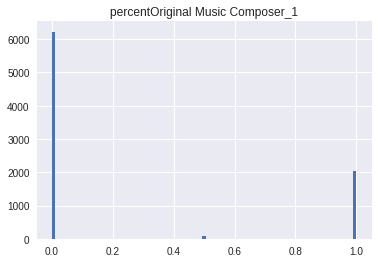

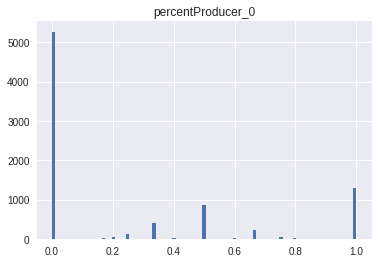

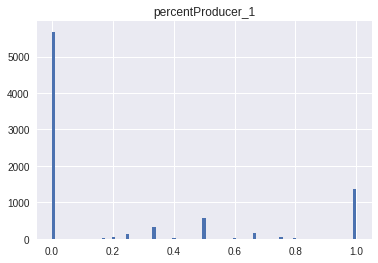

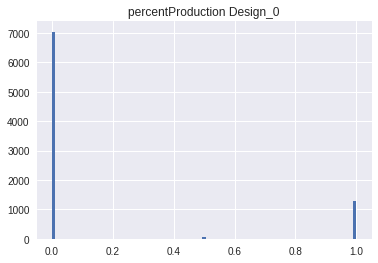

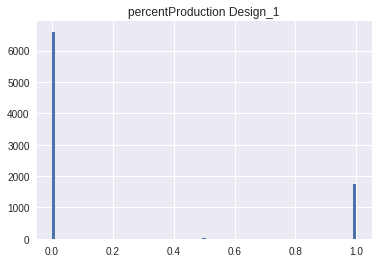

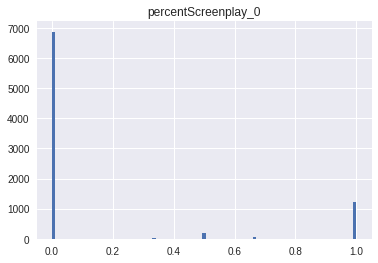

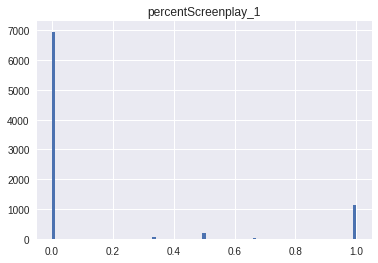

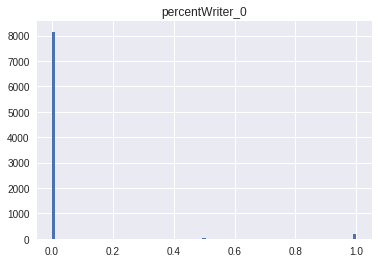

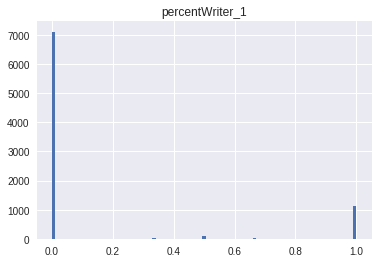

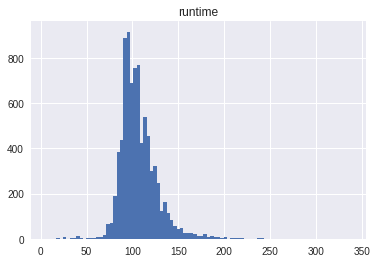

In [251]:
for col in myFeaturesList:
    plt.title(col)
    num_bins = int(np.sqrt(dfMoviesUS[col].notnull().sum()))
    plt.hist(dfMoviesUS[col].dropna().values,bins=num_bins)
    plt.show()

Considering the big amount of rows where budget in null, we will initially deploy a model excluding those rows:

###MODEL 1: RIDGE REGRESSOR FOR MOVIES WITH KNOWN BUDGET

In order to avoid the problems that mean a very skewed target, we will apply a model for movies with know revenue and log(revenue) as target. Besides, we will apply log(1+x) transformation to very skewed features.

In [252]:
myFeaturesList = ['budget_inflation_adjusted', 'runtime', 'intAnnual'] + dfMoviesUS.columns[dfMoviesUS.columns.str.contains('Roles')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('ind')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('percent')].tolist()
myFeaturesList.remove('indDrama')
myFeaturesList.remove('indCountries_Other')
myFeaturesList.remove('indCountryNull')
myFeaturesList.remove('indGenreNull')
myFeaturesList = list(set(myFeaturesList) - set(dfMoviesUS.columns[(dfMoviesUS.columns.str.startswith('percent')) & (dfMoviesUS.columns.str.contains('_2'))].tolist()))
myFeaturesList.sort()

len(myFeaturesList)

48

In [0]:
X=dfMoviesUS[dfMoviesUS['budget_inflation_adjusted'].notnull()][myFeaturesList]
y=dfMoviesUS[dfMoviesUS['budget_inflation_adjusted'].notnull()][['revenue_inflation_adjusted']].applymap(lambda x: np.log(x)).values.ravel()

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=True)

In [255]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
from sklearn.pipeline import make_union, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [0]:
def get_not_log_cols(df):
    return df[['3FirstRoles_High', '3FirstRoles_Medium', '3FirstRoles_Low', 'intAnnual', 'runtime'] + df.columns[df.columns.str.startswith('ind')].tolist() + df.columns[df.columns.str.startswith('percent')].tolist()]

def get_log_cols(df):
    return df[['budget_inflation_adjusted', 'OtherRoles_High', 'OtherRoles_Medium', 'OtherRoles_Low']]
  
def log_1(df):
    return df.applymap(lambda x: np.log(x+1))

In [0]:
model_1 = Pipeline(steps=[
    ('union', make_union(
    FunctionTransformer(get_not_log_cols, validate=False), 
    Pipeline(steps=[('get_log_cols', FunctionTransformer(get_log_cols, validate=False)), 
                    ('log_x_plus_1', FunctionTransformer(log_1, validate=False))])
    )), 
    ('linear_regression', RidgeCV())
                   ])   

In [259]:
model_1.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function get_not_log_cols at 0x7f6170ebb1e0>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False))...None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False))])

In [260]:
# The mean squared error
print("TRAIN - Mean squared error: %.2f"
      % mean_squared_error(y_train, model_1.predict(X_train)))
print("TEST - Mean squared error: %.2f"
      % mean_squared_error(y_test, model_1.predict(X_test)))

# Explained variance score: 1 is perfect prediction
print('TRAIN - R2 score: %.2f' % r2_score(y_train, model_1.predict(X_train)))
print('TEST - R2 score: %.2f' % r2_score(y_test, model_1.predict(X_test)))

TRAIN - Mean squared error: 2.77
TEST - Mean squared error: 2.78
TRAIN - R2 score: 0.56
TEST - R2 score: 0.55


In [261]:
# The coefficients
pd.Series(model_1.named_steps['linear_regression'].coef_, index=X.columns).sort_index()

3FirstRoles_High                      -0.226204
3FirstRoles_Low                       -0.155578
3FirstRoles_Medium                    -0.075528
OtherRoles_High                       -0.035888
OtherRoles_Low                         0.008030
OtherRoles_Medium                      0.670906
budget_inflation_adjusted              1.157407
indAnimationMusic                      1.014248
indCertific_G_PG                       0.588056
indCertific_PG13                       0.268363
indCertific_R_NC17                    -0.219346
indComedy                              0.183329
indCountries_Eur_only                  0.240516
indCountries_US_and_oth               -0.084569
indCountries_US_only                   0.248518
indDocumentaryHistoryWar              -0.649487
indFantasyScienceFiction               0.322791
indLang_ENG                            0.376867
indRomance                             0.480994
indThrillerHorrorActionCrimeMystery    0.490016
intAnnual                              0

Errors distribution:

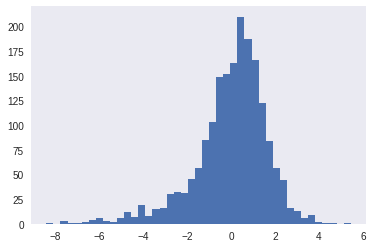

In [262]:
%matplotlib inline
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1,1)

num_bins = int(np.sqrt(len(y_test)))
plt.hist(y_test - model_1.predict(X_test), bins=num_bins);

plt.grid(False)

plt.title('')
plt.ylabel('')

figure.set_size_inches([6,4])

plt.show()

They are not far from normality.

In [263]:
pd.Series(y_test - model_1.predict(X_test)).describe()

count    1873.000000
mean       -0.005475
std         1.667552
min        -8.407986
25%        -0.735695
50%         0.251771
75%         1.022351
max         5.441596
dtype: float64

###MODEL 2: RANSAC REGRESSOR FOR MOVIES WITH KNOWN BUDGET

Model for movies with known revenue and log(revenue) as target. In this case, we will use a robust regressor as RANSAC. We keep log(revenue) as target to get a comparable model with the previous one. But we won´t apply log transformation to our features and we will see the result we get with this robust regressor.

In [264]:
myFeaturesList = ['budget_inflation_adjusted', 'runtime', 'intAnnual'] + dfMoviesUS.columns[dfMoviesUS.columns.str.contains('Roles')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('ind')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('percent')].tolist()
myFeaturesList.remove('indDrama')
myFeaturesList.remove('indCountries_Other')
myFeaturesList.remove('indCountryNull')
myFeaturesList.remove('indGenreNull')
myFeaturesList = list(set(myFeaturesList) - set(dfMoviesUS.columns[(dfMoviesUS.columns.str.startswith('percent')) & (dfMoviesUS.columns.str.contains('_2'))].tolist()))
myFeaturesList.sort()

len(myFeaturesList)

48

In [0]:
X=dfMoviesUS[dfMoviesUS['budget_inflation_adjusted'].notnull()][myFeaturesList]
y=dfMoviesUS[dfMoviesUS['budget_inflation_adjusted'].notnull()][['revenue_inflation_adjusted']].applymap(lambda x: np.log(x)).values.ravel()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=True)

In [0]:
from sklearn.linear_model import RANSACRegressor

In [0]:
model_2 = RANSACRegressor()

In [268]:
model_2.fit(X_train,y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=None, residual_metric=None,
        residual_threshold=None, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

In [269]:
# The mean squared error
print("TRAIN - Mean squared error: %.2f"
      % mean_squared_error(y_train, model_2.predict(X_train)))
print("TEST - Mean squared error: %.2f"
      % mean_squared_error(y_test, model_2.predict(X_test)))

TRAIN - Mean squared error: 16.64
TEST - Mean squared error: 17.16


Errors distribution:

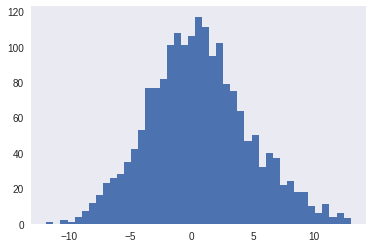

In [270]:
%matplotlib inline
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1,1)

num_bins = int(np.sqrt(len(y_test)))
plt.hist(y_test - model_2.predict(X_test), bins=num_bins);

plt.grid(False)
plt.title('')
plt.ylabel('')
figure.set_size_inches([6,4])

plt.show()

Not far from normality!

In [271]:
pd.Series(y_test - model_2.predict(X_test)).describe()

count    1873.000000
mean        0.596104
std         4.100704
min       -11.859641
25%        -2.171143
50%         0.420537
75%         3.119428
max        12.966086
dtype: float64

###MODEL 3: LASSO FOR MOVIES WITH KNOWN BUDGET

In order to avoid the problems that mean a very skewed target, we will apply a model for movies with know revenue and log(revenue) as target. Besides, we will apply log(1+x) transformation to very skewed features.

In [0]:
X=dfMoviesUS[dfMoviesUS['budget_inflation_adjusted'].notnull()][myFeaturesList]
y=dfMoviesUS[dfMoviesUS['budget_inflation_adjusted'].notnull()][['revenue_inflation_adjusted']].applymap(lambda x: np.log(x)).values.ravel()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=True)

In [0]:
def get_not_log_cols(df):
    return df[['3FirstRoles_High', '3FirstRoles_Medium', '3FirstRoles_Low', 'intAnnual', 'runtime'] + df.columns[df.columns.str.startswith('ind')].tolist() + df.columns[df.columns.str.startswith('percent')].tolist()]

def get_log_cols(df):
    return df[['budget_inflation_adjusted', 'OtherRoles_High', 'OtherRoles_Medium', 'OtherRoles_Low']]
    #return df[['budget_inflation_adjusted']]
  
def log_1(df):
    return df.applymap(lambda x: np.log(x+1))

In [0]:
from sklearn.linear_model import LassoCV, lasso_path, Lasso, LassoLarsCV, LassoLars

In [0]:
model_3 = Pipeline(steps=[
    ('union', make_union(
    FunctionTransformer(get_not_log_cols, validate=False), 
    Pipeline(steps=[('get_log_cols', FunctionTransformer(get_log_cols, validate=False)), 
                    ('log_x_plus_1', FunctionTransformer(log_1, validate=False))])
    )), 
    ('lasso', LassoCV(cv=3, random_state=42))
                   ])   

In [276]:
model_3.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function get_not_log_cols at 0x7f6173bc4950>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False))...=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=False))])

In [277]:
# The mean squared error
print("TRAIN - Mean squared error: %.2f"
      % mean_squared_error(y_train, model_3.predict(X_train)))
print("TEST - Mean squared error: %.2f"
      % mean_squared_error(y_test, model_3.predict(X_test)))

# Explained variance score: 1 is perfect prediction
print('TRAIN - R2 score: %.2f' % r2_score(y_train, model_3.predict(X_train)))
print('TEST - R2 score: %.2f' % r2_score(y_test, model_3.predict(X_test)))

TRAIN - Mean squared error: 2.86
TEST - Mean squared error: 2.87
TRAIN - R2 score: 0.54
TEST - R2 score: 0.53


In [278]:
coefficients = pd.Series(model_3.named_steps['lasso'].coef_, index=X.columns).sort_index()
coefficients[coefficients != 0].shape

(28,)

In [279]:
# The coefficients
pd.Series(model_3.named_steps['lasso'].coef_, index=X.columns).sort_index()

3FirstRoles_High                      -0.112624
3FirstRoles_Low                       -0.035185
3FirstRoles_Medium                     0.000000
OtherRoles_High                       -0.031434
OtherRoles_Low                         0.007103
OtherRoles_Medium                      0.295580
budget_inflation_adjusted              0.719302
indAnimationMusic                      0.532458
indCertific_G_PG                       0.132514
indCertific_PG13                      -0.000000
indCertific_R_NC17                    -0.156109
indComedy                              0.000000
indCountries_Eur_only                  0.024788
indCountries_US_and_oth               -0.151199
indCountries_US_only                   0.000000
indDocumentaryHistoryWar              -0.000000
indFantasyScienceFiction               0.000000
indLang_ENG                            0.073556
indRomance                             0.000000
indThrillerHorrorActionCrimeMystery    0.000000
intAnnual                              0

###MODEL 4: LINEAR REGRESSION - BUDGET VS REVENUE

In order to know how much variance in revenue is explained by budget, we perform a linear regression model considering only budget (and log transformation in revenue and budget).

In [0]:
X=dfMoviesUS[dfMoviesUS['budget_inflation_adjusted'].notnull()][['budget_inflation_adjusted']].applymap(lambda x: np.log(x))
y=dfMoviesUS[dfMoviesUS['budget_inflation_adjusted'].notnull()][['revenue_inflation_adjusted']].applymap(lambda x: np.log(x)).values.ravel()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=True)

In [281]:
model_4 = LinearRegression()
model_4.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [282]:
# The mean squared error
print("TRAIN - Mean squared error: %.2f"
      % mean_squared_error(y_train, model_4.predict(X_train)))
print("TEST - Mean squared error: %.2f"
      % mean_squared_error(y_test, model_4.predict(X_test)))

# Explained variance score: 1 is perfect prediction
print('TRAIN - R2 score: %.2f' % r2_score(y_train, model_4.predict(X_train)))
print('TEST - R2 score: %.2f' % r2_score(y_test, model_4.predict(X_test)))

TRAIN - Mean squared error: 3.42
TEST - Mean squared error: 3.39
TRAIN - R2 score: 0.45
TEST - R2 score: 0.45


###MODEL 5: RIDGE REGRESSOR - ALL FEATURES BUT BUDGET

In [283]:
myFeaturesList = ['runtime', 'intAnnual'] + dfMoviesUS.columns[dfMoviesUS.columns.str.contains('Roles')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('ind')].tolist() + dfMoviesUS.columns[dfMoviesUS.columns.str.startswith('percent')].tolist()
myFeaturesList.remove('indDrama')
myFeaturesList.remove('indCountries_Other')
myFeaturesList.remove('indCountryNull')
myFeaturesList.remove('indGenreNull')
myFeaturesList = list(set(myFeaturesList) - set(dfMoviesUS.columns[(dfMoviesUS.columns.str.startswith('percent')) & (dfMoviesUS.columns.str.contains('_2'))].tolist()))
myFeaturesList.sort()

len(myFeaturesList)

47

In [0]:
X=dfMoviesUS[myFeaturesList]
y=dfMoviesUS[['revenue_inflation_adjusted']].applymap(lambda x: np.log(x)).values.ravel()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, shuffle=True)

In [0]:
def get_not_log_cols(df):
    return df[['3FirstRoles_High', '3FirstRoles_Medium', '3FirstRoles_Low', 'intAnnual', 'runtime'] + df.columns[df.columns.str.startswith('ind')].tolist() + df.columns[df.columns.str.startswith('percent')].tolist()]

def get_log_cols(df):
    return df[['OtherRoles_High', 'OtherRoles_Medium', 'OtherRoles_Low']]
  
def log_1(df):
    return df.applymap(lambda x: np.log(x+1))

In [0]:
model_5 = Pipeline(steps=[
    ('union', make_union(
    FunctionTransformer(get_not_log_cols, validate=False), 
    Pipeline(steps=[('get_log_cols', FunctionTransformer(get_log_cols, validate=False)), 
                    ('log_x_plus_1', FunctionTransformer(log_1, validate=False))])
    )), 
    ('Ridge', RidgeCV())
                   ]) 

In [287]:
model_5.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function get_not_log_cols at 0x7f6173bc4510>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False))...None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False))])

In [288]:
# The mean squared error
print("TRAIN - Mean squared error: %.2f"
      % mean_squared_error(y_train, model_5.predict(X_train)))
print("TEST - Mean squared error: %.2f"
      % mean_squared_error(y_test, model_5.predict(X_test)))

# Explained variance score: 1 is perfect prediction
print('TRAIN - R2 score: %.2f' % r2_score(y_train, model_5.predict(X_train)))
print('TEST - R2 score: %.2f' % r2_score(y_test, model_5.predict(X_test)))

TRAIN - Mean squared error: 3.81
TEST - Mean squared error: 4.06
TRAIN - R2 score: 0.51
TEST - R2 score: 0.49


In [289]:
coefficients = pd.Series(model_5.named_steps['Ridge'].coef_, index=X.columns).sort_index()
coefficients[coefficients != 0]

3FirstRoles_High                       0.241063
3FirstRoles_Low                        0.224562
3FirstRoles_Medium                     0.262543
OtherRoles_High                       -0.058577
OtherRoles_Low                         0.016288
OtherRoles_Medium                      1.367740
indAnimationMusic                      1.879812
indCertific_G_PG                       1.767120
indCertific_PG13                       1.020201
indCertific_R_NC17                     0.727601
indComedy                             -0.263852
indCountries_Eur_only                  0.249163
indCountries_US_and_oth                0.230756
indCountries_US_only                   0.440955
indDocumentaryHistoryWar               0.848140
indFantasyScienceFiction              -0.894017
indLang_ENG                            0.704246
indRomance                             0.776634
indThrillerHorrorActionCrimeMystery    1.361580
intAnnual                              1.023773
percentAnimation_0                     0